In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

# Definindo algumas funções para simplificar o código, que mais adiante serão chamados
# Primeiro método vai separar variaveis númericas e categorias, é útil para análise exploratória em dados onde não se conhecem todas as dimensões
def categorizar_num_cat(dados):
    var_categoricas = []
    var_numericas = []
    for col in dados.columns:
      if pd.api.types.is_numeric_dtype(dados[col].dtype):
        var_numericas.append(col)
      elif pd.api.types.is_object_dtype(dados[col].dtype):
        var_categoricas.append(col)
    return var_categoricas, var_numericas

# Segundo método para codificar as features categóricas, usando LabelEncoder
def codificar_cat(dados, var_categorias):
    le = LabelEncoder()
    for i in var_categorias:
        dados[i] = le.fit_transform(dados[i])
    return dados

# definindo a classe que vai escalar e padronizar as variaveis, na etapa de treinamento faremos a chamada dessa classe
class escalador_padronizador:
  def __init__(self):
    self.min_max_scaler = MinMaxScaler()
    self.standard_scaler = StandardScaler()

  def fit_transform(self,X_train):
    X_train_scaled = self.min_max_scaler.fit_transform(X_train)
    return self.standard_scaler.fit_transform(X_train_scaled)

  def transform(self,X_test):
    X_test_scaled = self.min_max_scaler.transform(X_test)
    return self.standard_scaler.transform(X_test_scaled)


# definindo a classe que vai selecionar os melhores parâmetros passados para os modelos, faremos o comparativo de KNN e RandomForest futuramente
class SelecionarParametros():
  def __init__(self, modelo, dict_params, cv=3):
    # argumentos para a classe:
    # modelo: Modelo de Machine Learning
    # dict_params: Dicionário com os hiperparâmetros a serem testados do modelo
    # cv: Número de folds para Cross-Validation (default = 3).self.modelo = modelo
    self.modelo = modelo
    self.dict_params = dict_params
    self.cv = cv
    self.grid_search = None
    self.resultados = None

  def fit(self,X_train,y_train):
      # vai executar a instância GridSearchCV para fazer o Benchmark dos parametros do modelo
      self.grid_search =  GridSearchCV(self.modelo, self.dict_params, cv=self.cv)
      self.grid_search.fit(X_train, y_train)
      self.resultados = pd.DataFrame(self.grid_search.cv_results_)

  def melhores_parametros(self):
    if self.grid_search:
      return self.grid_search.best_params_
    else:
      return None

  def melhor_acuracia(self):
    if self.grid_search:
        return self.grid_search.best_score_
    else:
      return None

  def treinamentos(self):
    if self.grid_search:
      return self.resultados.shape[0]
    else:
      return None


# carregando os dados no df
caminho_dados = r'/content/dados.csv'
dados = pd.read_csv(caminho_dados, sep=',')

# verificando a dimensionalidade do dataframe e contabilizando valores nulos
dados.shape
dados.head()


,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,...,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude
0,322057777715,38,F,8500.0,SC,22.0,170,2022-06-01,159,200000.0,...,1,SOLTEIRO(A),Nenhum,N,0.0,3,71.0,234064.38,12982.52,Nao
1,322057780715,47,F,1200.0,BA,18.0,25,2022-06-01,10,11000.0,...,1,SOLTEIRO(A),NaN,N,0.0,16,468.0,12800.79,530.22,Sim
2,322057786715,82,F,2300.0,SP,28.0,48,2022-06-01,36,10000.0,...,1,VIÚVO(A),NaN,N,0.0,16,468.0,13101.68,275.00,Sim
3,322057794715,21,F,1684.2,SP,21.0,50,2022-06-10,37,10000.0,...,2,SOLTEIRO(A),Nenhum,N,0.0,0,NaN,4299.36,8374.05,Nao
4,322057795715,64,M,3500.0,SP,24.0,25,2022-06-01,8,3000.0,...,0,CASADO (A),NaN,N,0.0,16,468.0,3785.15,153.60,Sim


In [ ]:
# Observando os dados, podemos fazer alguns ajustes que vão auxiliar na análise, o primeiro deles é criar uma faixa para idade, salário, dias em atraso e prazos.
bins_idade = [0, 21, 30, 40, 50, 60, 100]
labels_idade = ['Até 21 Anos',
                'De 22 até 30 Anos',
                'De 31 até 40 Anos',
                'De 41 até 50 Anos',
                'De 51 até 60',
                'Acima de 60 Anos']

dados['Faixa_Etaria'] = pd.cut(dados['Idade'], bins=bins_idade, labels=labels_idade)

bins_salario = [-100, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 9000000000]
labels_salario = [
    'Até R$1000',
    'De R$1000 até R$2000',
    'De R$2000 até R$3000',
    'De R$3000 até R$5000',
    'De R$5000 até R$10000',
    'De R$10000 até R$20000',
    'De R$20000 até R$30000',
    'Acima de R$30000'
]
dados['Faixa_Salarial'] = pd.cut(dados['Valor_Renda'].astype(float), bins=bins_salario, labels=labels_salario)

bins_dias_atraso = [-100, 30, 60, 90, 180, 240, 360, 500] #removed bins =
labels_dias_atraso = ['Até 30 dias',
          'De 31 até 60 ',
          'De 61 até 90',
          'De 91 até 180',
          'De 181 até 240','De 241 até 360',
          'Acima de 360']

# para os dias de atraso nulos preenchemos os valores com as medianas
dados['QT_Dias_Atraso'] = dados['QT_Dias_Atraso'].fillna((dados['QT_Dias_Atraso'].median()))
dados['Faixa_Dias_Atraso'] = pd.cut(dados['QT_Dias_Atraso'], bins=bins_dias_atraso, labels=labels_dias_atraso)

bins_prazo_emp = [0, 60, 120, 200, 720] #changed to bins_prazo_emp
labels_prazo_emp = ['Até 60 Meses',
          'De 61 até 120 Meses',
          'De 121 até 200 Meses',
          'Acima de 200 Meses']
dados['Faixa_Prazo_Emprestimo'] = pd.cut(dados['Prazo_Emprestimo'], bins=bins_prazo_emp, labels=labels_prazo_emp)

bins_prazo_rest = [-1, 60, 120, 200, 500] #changed to bins_prazo_rest
labels_prazo_rest = ['Até 60 Meses',
                     'De 61 até 120 Meses',
                     'De 121 até 200 Meses',
                     'Acima de 200 Meses']
dados['Faixa_Prazo_Restante'] = pd.cut(dados['Prazo_Restante'], bins=bins_prazo_rest, labels=labels_prazo_rest)

# mostrando os resultados das colunas de faixas
dados[['Faixa_Salarial', 'Faixa_Etaria','Faixa_Dias_Atraso', 'Faixa_Prazo_Emprestimo','Faixa_Prazo_Restante']].head()

,Faixa_Salarial,Faixa_Etaria,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante
0,De R$5000 até R$10000,De 31 até 40 Anos,De 61 até 90,De 121 até 200 Meses,De 121 até 200 Meses
1,De R$1000 até R$2000,De 41 até 50 Anos,Acima de 360,Até 60 Meses,Até 60 Meses
2,De R$2000 até R$3000,Acima de 60 Anos,Acima de 360,Até 60 Meses,Até 60 Meses
3,De R$1000 até R$2000,Até 21 Anos,De 241 até 360,Até 60 Meses,Até 60 Meses
4,De R$3000 até R$5000,Acima de 60 Anos,Acima de 360,Até 60 Meses,Até 60 Meses


<Axes: title={'center': 'Possíveis Fraudes'}, xlabel='Possivel_Fraude'>

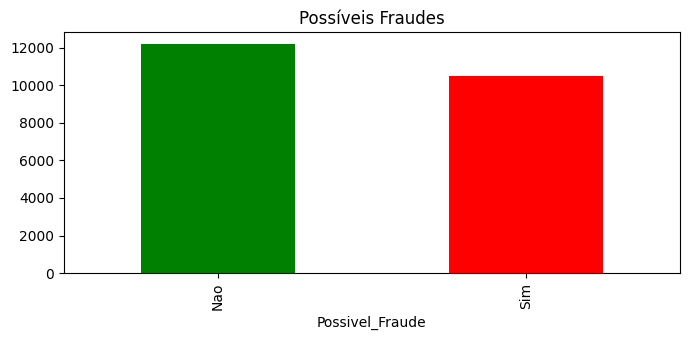

In [ ]:
# Verificando as amostras da variavel alvo 'Possivel_Fraude'
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
dados.Possivel_Fraude.value_counts().plot(kind='bar', title='Possíveis Fraudes',color = ['#008000', '#FF0000',])


In [ ]:
# definindo os tipos de variaveis do dataframe
categoricas, numericas = categorizar_num_cat(dados)
print(f'variavies categóricas{categoricas}')
print(f'variaveis numericas{numericas}')

variavies categóricas['Sexo', 'UF_Cliente', 'Data_Contratacao', 'Estado_Civil', 'Escolaridade', 'Possui_Patrimonio', 'Possivel_Fraude']
variaveis numericas['Contrato', 'Idade', 'Valor_Renda', 'Perc_Juros', 'Prazo_Emprestimo', 'Prazo_Restante', 'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas', 'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso', 'Qt_Renegociacao', 'VL_Patrimonio', 'QT_Parcelas_Atraso', 'QT_Dias_Atraso', 'Saldo_Devedor', 'Total_Pago']


In [ ]:
# agora com a classificação das variaveis podemos ainda eliminar algumas delas que não impactam no alvo como:
# contrato que se trata praticamente de um ID
# Data_Contratacao porque não vamos trabalhar com séries temporais
# VL_Patrimonio, Possui_Patrimonio, Escolaridade, Idade também não impactam no modelo
# Valor_Renda, Prazo_Emprestimo, QT_Dias_Atraso, Prazo_Restante ja foram categorizados em faixas anteriormente

dados.drop(columns=['Contrato', 'Data_Contratacao', 'VL_Patrimonio',
                    'Possui_Patrimonio', 'Escolaridade', 'Idade',
                    'Valor_Renda', 'Prazo_Emprestimo',
                    'QT_Dias_Atraso', 'Prazo_Restante'], inplace=True, errors='ignore')

dados.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude,Faixa_Etaria,Faixa_Salarial,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante
0,F,SC,22.0,200000.0,230000.0,14,4,0,1,SOLTEIRO(A),3,234064.38,12982.52,Nao,De 31 até 40 Anos,De R$5000 até R$10000,De 61 até 90,De 121 até 200 Meses,De 121 até 200 Meses
1,F,BA,18.0,11000.0,12650.0,1,1,0,1,SOLTEIRO(A),16,12800.79,530.22,Sim,De 41 até 50 Anos,De R$1000 até R$2000,Acima de 360,Até 60 Meses,Até 60 Meses
2,F,SP,28.0,10000.0,11500.0,1,1,0,1,VIÚVO(A),16,13101.68,275.00,Sim,Acima de 60 Anos,De R$2000 até R$3000,Acima de 360,Até 60 Meses,Até 60 Meses
3,F,SP,21.0,10000.0,11500.0,15,3,1,2,SOLTEIRO(A),0,4299.36,8374.05,Nao,Até 21 Anos,De R$1000 até R$2000,De 241 até 360,Até 60 Meses,Até 60 Meses
4,M,SP,24.0,3000.0,3450.0,1,1,0,0,CASADO (A),16,3785.15,153.60,Sim,Acima de 60 Anos,De R$3000 até R$5000,Acima de 360,Até 60 Meses,Até 60 Meses


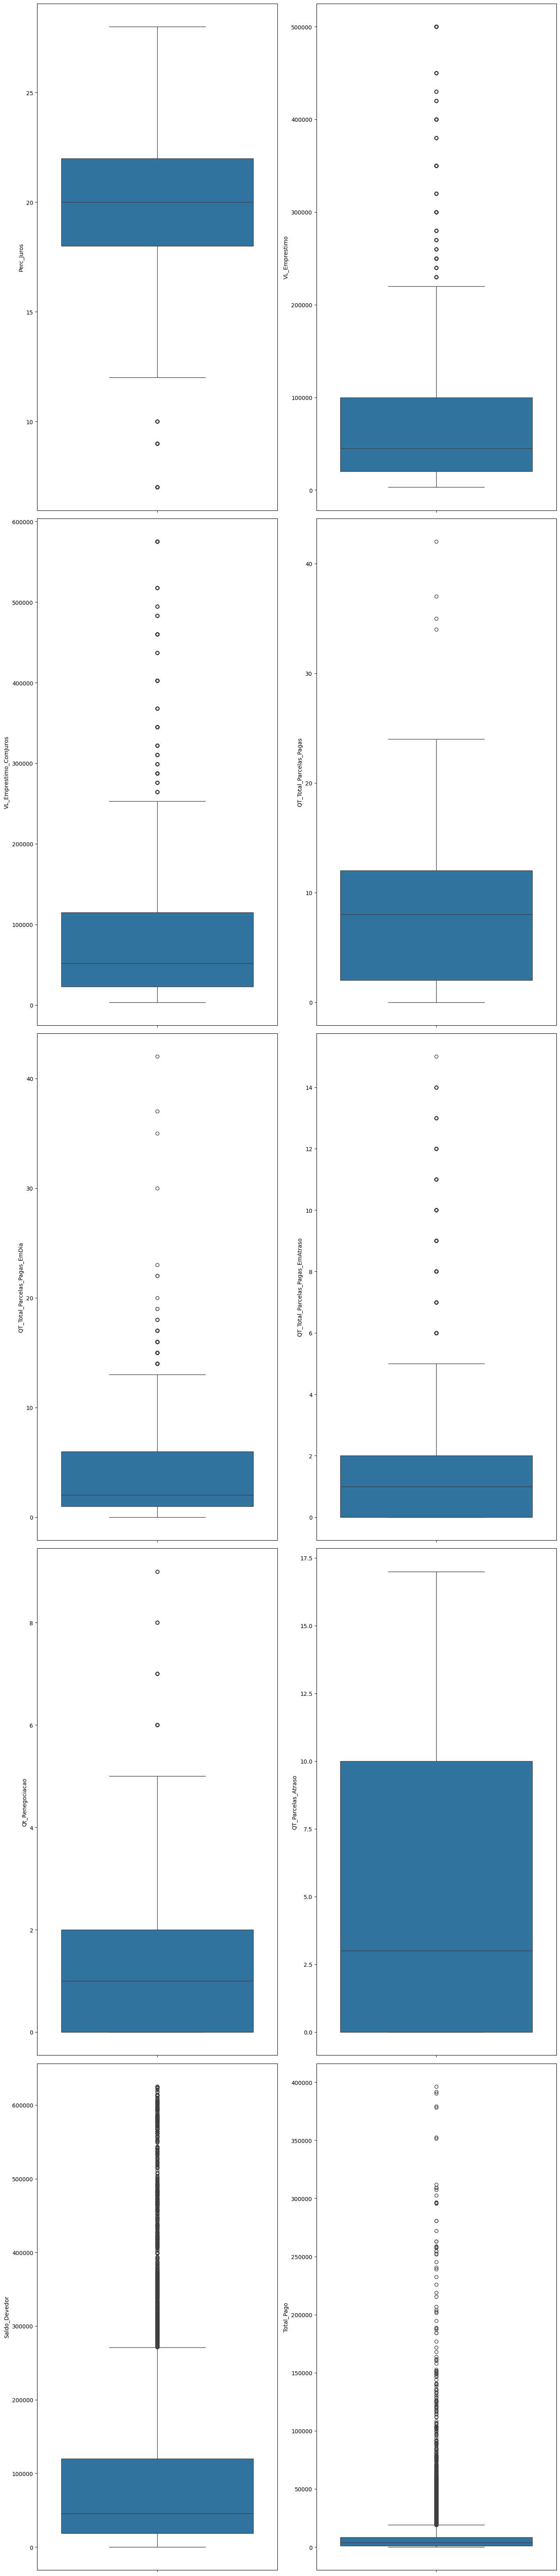

In [ ]:
# vamos iniciar a detecção de outliers nas variáveis númericas, para maximizar o desempenho do modelo
# O boxplot é uma boa alternativa para averiguar esse tipo de dados

# Redefine 'numericas' após dropar as colunas
categoricas, numericas = categorizar_num_cat(dados)

plt.rcParams["figure.figsize"] = [14.00, 64.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(5, 2) #5 linhas e 2 colunas

linha = 0
coluna = 0
for i in numericas:
    sns.boxplot(data = dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

In [ ]:
# agora vamos usar o codificador para as variaveis categoricas, com excessão da variável Alvo
var_categoricas = [col for col in dados.columns if col != 'Possivel_Fraude']
print(var_categoricas)
dados = codificar_cat(dados, var_categorias=var_categoricas)
dados.head()

['Sexo', 'UF_Cliente', 'Perc_Juros', 'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas', 'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso', 'Qt_Renegociacao', 'Estado_Civil', 'QT_Parcelas_Atraso', 'Saldo_Devedor', 'Total_Pago', 'Faixa_Etaria', 'Faixa_Salarial', 'Faixa_Dias_Atraso', 'Faixa_Prazo_Emprestimo', 'Faixa_Prazo_Restante']


,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude,Faixa_Etaria,Faixa_Salarial,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante
0,0,23,22,48,48,14,4,0,1,4,3,16313,12731,Nao,3,7,5,2,2
1,0,4,15,11,11,1,1,0,1,4,16,3611,582,Sim,4,2,0,1,1
2,0,25,27,10,10,1,1,0,1,6,16,3695,137,Sim,0,4,0,1,1
3,0,25,21,10,10,15,3,1,2,4,0,602,10658,Nao,1,2,3,1,1
4,1,25,24,0,0,1,1,0,0,0,16,457,17,Sim,0,6,0,1,1


<Axes: title={'center': 'Possíveis Fraudes'}, xlabel='Possivel_Fraude'>

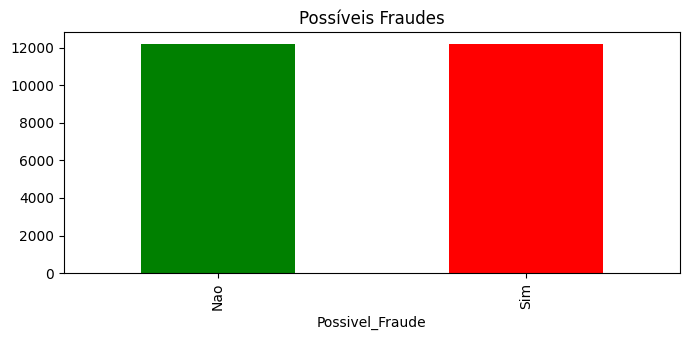

In [ ]:
# separando features e target
features = dados.drop('Possivel_Fraude', axis=1)
target = dados['Possivel_Fraude']

# precisamos aplicar um método para balancear os alvos, visto que diferentes quantidade entre as categorias dentro do alvo atrapalham o modelo
seed = 100
balancer = SMOTE(random_state=seed)
features_res, target_res = balancer.fit_resample(features, target)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
target_res.value_counts().plot(kind='bar', title='Possíveis Fraudes',color = ['#008000', '#FF0000',])


In [ ]:
# separando em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(features_res, target_res, test_size = 0.2, random_state = 42)

# escalonando e padronizando as variáveis, usando a classe declarada escalador_padronizador, que retorna os conjuntos ja escalonados e padronizados

scaler = escalador_padronizador()
X_train = scaler.fit_transform(X_train=X_train)
X_test = scaler.transform(X_test=X_test)

In [ ]:

# parametros do modelo rf
dict_params_rf = {
    "n_estimators": np.array([100, 200, 300]),
    "max_depth": np.array([10, 20]),
    "criterion": np.array(["gini", "entropy"]),
    "max_features": np.array(["sqrt", "log2", None]),
    "min_samples_split": np.array([2, 5]),
    "min_samples_leaf": np.array([1, 2, 3])
}

# parametros do modelo knn
dict_params_knn = {
  'n_neighbors' : np.array([3,4,5,6,7]),
  'algorithm' : np.array(['auto', 'ball_tree', 'kd_tree', 'brute']),
  'leaf_size' : np.array([30,31,32]),
  'metric' :  np.array(['minkowski','euclidean'])
}

# selecionando os melhores parametros para os modelos com a instância SelecionarParametros
best_rf = SelecionarParametros(modelo=RandomForestClassifier(), dict_params=dict_params_rf,cv=3)
best_rf.fit(X_train, Y_train)
modelo_rf = {
    'melhores_parametros': best_rf.melhores_parametros(),
    'melhor_acuracia': str(round(best_rf.melhor_acuracia() *100,2))+'%',
    'treinamentos': best_rf.treinamentos()
}



best_knn = SelecionarParametros(modelo=KNeighborsClassifier(), dict_params=dict_params_knn,cv=3)
best_knn.fit(X_train, Y_train)
modelo_knn = {
    'melhores_parametros': best_knn.melhores_parametros(),
    'melhor_acuracia': str(round(best_knn.melhor_acuracia() *100,2))+'%',
    'treinamentos': best_knn.treinamentos()
}



In [ ]:
resumo = pd.DataFrame({'Random Forest':pd.Series(modelo_rf),
                       'KNN':pd.Series(modelo_knn)})
resumo

,Random Forest,KNN
melhores_parametros,"{'criterion': 'entropy', 'max_depth': 10, 'max...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
melhor_acuracia,99.25%,96.72%
treinamentos,216,120


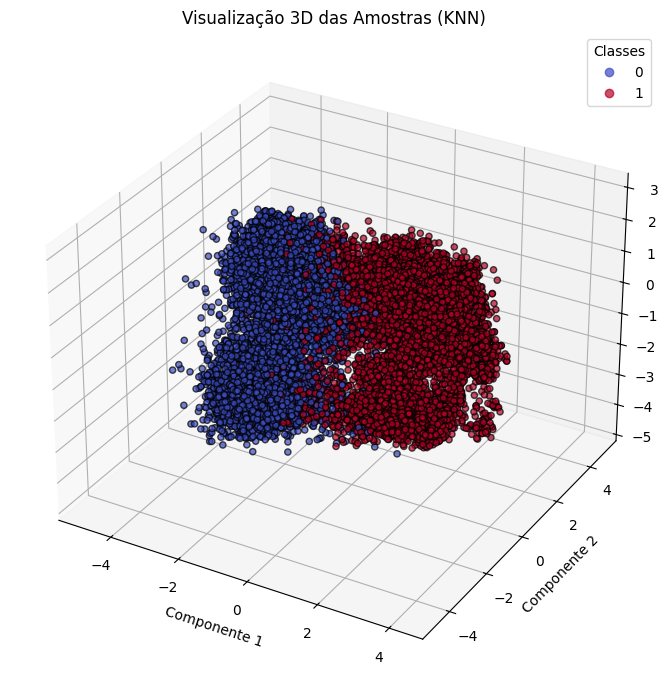

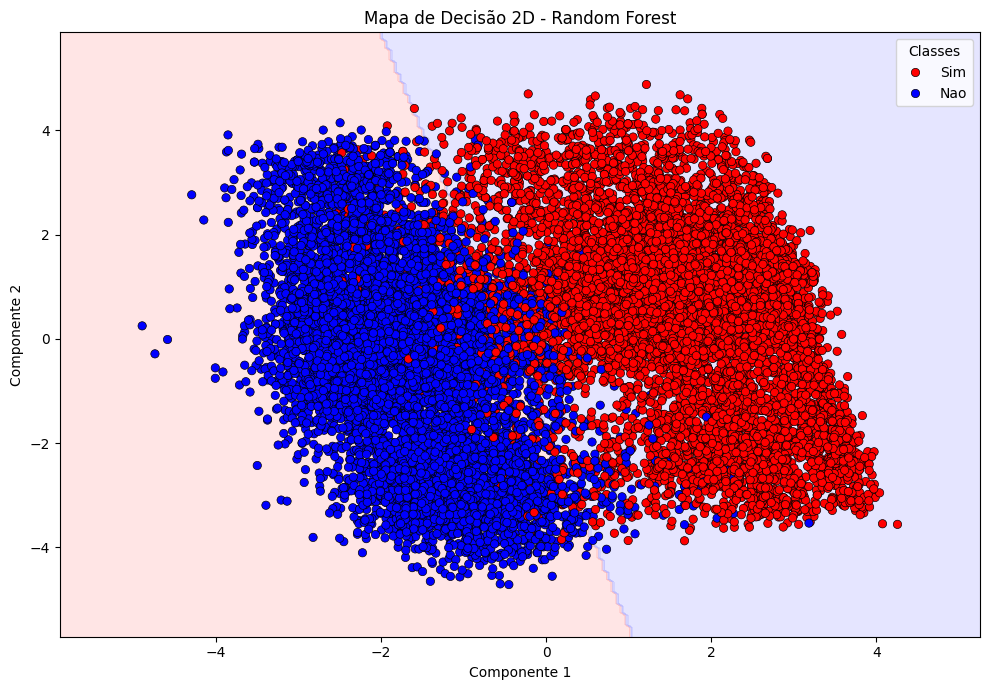

In [ ]:


from sklearn.decomposition import PCA # reduz a dimensionalidade dos dados
from mpl_toolkits.mplot3d import Axes3D # importa gráficos 3d do matplotlib, deixando insights mais claros em conjuntos complexos
from matplotlib.colors import ListedColormap

# Ajustando o modelo KNN e RandomForest com os melhores parametros benchmarks
rf_model = RandomForestClassifier(**modelo_rf['melhores_parametros'], random_state=42)
rf_model.fit(X_train, Y_train)

knn_model = KNeighborsClassifier(**modelo_knn['melhores_parametros'])
knn_model.fit(X_train, Y_train)

# ajustando as visualizações para entendimento dos modelos
# Reduzindo as dimensões para 3 para visualizar o KNN
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train)

# Criando gráfico 3D para visualizar proximidade das amostras no KNN
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# converte as classes do alvo
Y_train_numeric = Y_train.map({'Sim': 1, 'Nao': 0})

scatter = ax.scatter(X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2], # divide os componentes principais do PCA em 3
                      c=Y_train_numeric, cmap='coolwarm', edgecolors='k', alpha=0.7)

ax.set_title('Visualização 3D das Amostras (KNN)')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

# Reduzindo as dimensões para 2D para o mapa de decisão do Random Forest
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Definindo os limites dos eixos do gráfico de mapa
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# salvando as métricas que servirão para calcular a previsão do modelo em cada ponto
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
# inverte as métricas para antes da redução de dimensionalidade com PCA
meshgrid_points_original = pca_2d.inverse_transform(meshgrid_points)

# fazendo a previsão
Z = rf_model.predict(meshgrid_points_original)
# converte as classes do alvo
Z_numeric = np.where(Z == 'Sim', 1, 0)
Z = Z_numeric.reshape(xx.shape)

# Plotando o mapa de decisão do Random Forest
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
sns.scatterplot(x=X_train_pca_2d[:, 0], y=X_train_pca_2d[:, 1], hue=Y_train, palette=['red', 'blue'], edgecolor='k')
plt.title('Mapa de Decisão 2D - Random Forest')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title="Classes")
plt.show()
